In [1]:
import pandas as pd
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import plotly.express as px
from plotly.offline import iplot, init_notebook_mode
import matplotlib.pylab as pylab
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode
import pickle
from textblob import TextBlob

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm

from sklearn.metrics import accuracy_score, precision_score, recall_score,confusion_matrix
from sklearn.pipeline import Pipeline






In [3]:
df=pd.read_csv("Verbatims-20131231.csv")

In [4]:
df.head(5)

,Survey,Sequence8,Completed On,Name,City,Question Code,Verbatim
0,2013 NVES,16176609,20130815,Marco D.,NaN,NVES4001,"Great vehicle, but the dealer took way too lon..."
1,2013 NVES,16206634,20130815,Judith M.,NaN,NVES4001,LOVE electric vehicle--especially the fiat
2,2013 NVES,16161488,20130815,Alejandro G.,NaN,NVES4001,I love my jeep
3,2013 NVES,16168068,20130815,Beth S.,NaN,NVES4000,I wanted to get something with better fuel eco...
4,2013 NVES,16168068,20130815,Beth S.,NaN,NVES4001,The Jeep Compass needs additional interior sto...


In [7]:
df.nunique()

Survey               1
Sequence8        19255
Completed On       250
Name              9461
City                 0
Question Code        3
Verbatim         26929
dtype: int64

In [5]:
df=df.drop(['Survey','City','Sequence8'],axis=1)

In [8]:
df.describe(include='all')

,Completed On,Name,Question Code,Verbatim
count,2.726000e+04,27260,27260,27260
unique,NaN,9461,3,26929
top,NaN,John S.,NVES4001,Too expensive
freq,NaN,86,12590,43
mean,2.013123e+07,NaN,NaN,NaN
std,1.915598e+03,NaN,NaN,NaN
min,2.013052e+07,NaN,NaN,NaN
25%,2.013070e+07,NaN,NaN,NaN
50%,2.013083e+07,NaN,NaN,NaN
75%,2.013100e+07,NaN,NaN,NaN


In [6]:
df.columns=['date','name','question_code','text']

In [7]:
df['date'] = df['date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
df['year']=df['date'].dt.year

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27260 entries, 0 to 27259
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           27260 non-null  datetime64[ns]
 1   name           27260 non-null  object        
 2   question_code  27260 non-null  object        
 3   text           27260 non-null  object        
 4   year           27260 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 1.0+ MB


In [12]:
count=round(df.isnull().sum(),2)
percent=round((df.isnull().sum()/df.shape[0])*100,2)
data=pd.concat([count,percent],axis=1)
data.reset_index(inplace=True)
data.rename(columns={0: 'Missing Values Count',1: 'Missing Values %'},inplace=True)
data[data['Missing Values Count']!=0]

,index,Missing Values Count,Missing Values %


In [8]:
df.replace(to_replace =["NVES4001", "NVES4002","NVES4000"], 
                            value =["4001","4002","4000"])

,date,name,question_code,text,year
0,2013-08-15,Marco D.,4001,"Great vehicle, but the dealer took way too lon...",2013
1,2013-08-15,Judith M.,4001,LOVE electric vehicle--especially the fiat,2013
2,2013-08-15,Alejandro G.,4001,I love my jeep,2013
3,2013-08-15,Beth S.,4000,I wanted to get something with better fuel eco...,2013
4,2013-08-15,Beth S.,4001,The Jeep Compass needs additional interior sto...,2013
...,...,...,...,...,...
27255,2013-10-14,Jerry M.,4002,Just as happy as you can be...,2013
27256,2013-10-25,Waldemar D.,4002,Road noise is worse then my 2006 Honda Civic. ...,2013
27257,2013-10-15,Mary M.,4002,I have noticed that I some times get alert mes...,2013
27258,2013-10-22,Julie H.,4002,I am extremely unhappy with the gas mileage th...,2013


In [9]:
#This function converts to lower-case, removes square bracket, removes numbers and punctuation
def text_clean(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    return text

cleaned = lambda x: text_clean(x)

In [10]:
df['text'] = pd.DataFrame(df.text.apply(cleaned))

In [11]:
df.head()

,date,name,question_code,text,year
0,2013-08-15,Marco D.,NVES4001,great vehicle but the dealer took way too long...,2013
1,2013-08-15,Judith M.,NVES4001,love electric vehicleespecially the fiat,2013
2,2013-08-15,Alejandro G.,NVES4001,i love my jeep,2013
3,2013-08-15,Beth S.,NVES4000,i wanted to get something with better fuel eco...,2013
4,2013-08-15,Beth S.,NVES4001,the jeep compass needs additional interior sto...,2013


In [12]:
df['sentiment'] = df['text'].apply(lambda x: 'positive' if(TextBlob(x).sentiment.polarity>0.2) else 'negative')

In [13]:
df.head()

,date,name,question_code,text,year,sentiment
0,2013-08-15,Marco D.,NVES4001,great vehicle but the dealer took way too long...,2013,negative
1,2013-08-15,Judith M.,NVES4001,love electric vehicleespecially the fiat,2013,positive
2,2013-08-15,Alejandro G.,NVES4001,i love my jeep,2013,positive
3,2013-08-15,Beth S.,NVES4000,i wanted to get something with better fuel eco...,2013,positive
4,2013-08-15,Beth S.,NVES4001,the jeep compass needs additional interior sto...,2013,negative


In [14]:
rslt_df=pd.DataFrame()
rslt_df = df.text[df.text.str.contains('jeep compass')]
rslt_df.head()

4      the jeep compass needs additional interior sto...
161    the jeep compass had more favorable lease options
233    except that i love my jeep compass and the dea...
578    it would be nice if the jeep compass comes wit...
741    ive driven chrysler for many years and wanted ...
Name: text, dtype: object

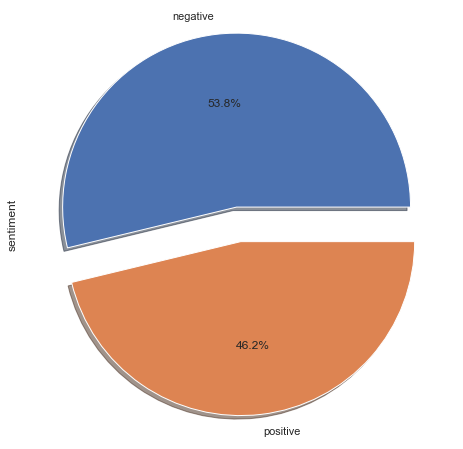

In [63]:
df['sentiment'].value_counts().plot.pie(explode=[0.1,0.1],autopct='%1.1f%%',shadow=True,figsize=(10,8))
plt.show()

In [26]:
pos_messages = df[df["sentiment"] == "positive"]["text"]
neg_messages = df[df["sentiment"] == "negative"]["text"]

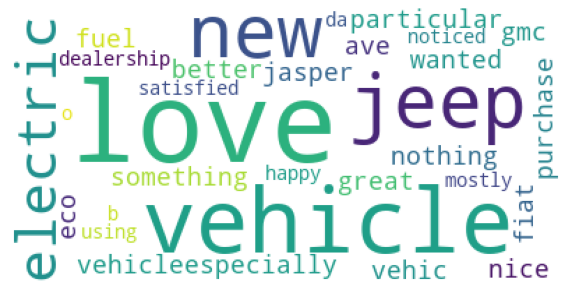

In [27]:
wordcloud = WordCloud(max_font_size=80,max_words=30, background_color="white").generate(str(pos_messages))
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

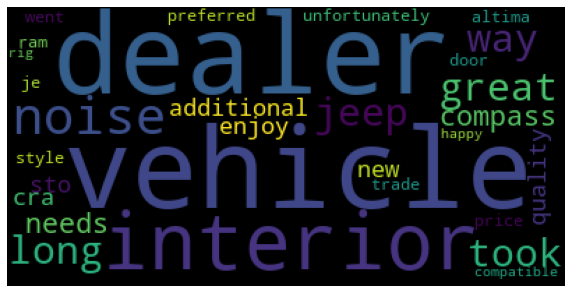

In [28]:
wordcloud = WordCloud(max_font_size=80,max_words=30, background_color="black").generate(str(neg_messages))
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Text(0.5, 1.0, 'plotting year')

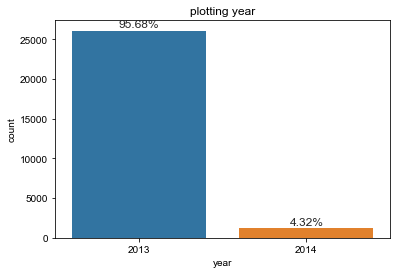

In [18]:
def barplot(column,data):
    bar_plot1=sns.countplot(x=column,data=data)
   
    total=len(data[column])
    for p in bar_plot1.patches:
        percentage='{:.2f}%'.format(100*p.get_height()/total)
        height=p.get_height()
        sns.set(style="darkgrid")
        bar_plot1.text(p.get_x()+p.get_width()/2,height+400,percentage,ha='center')
barplot('year',df)
plt.title('plotting year')

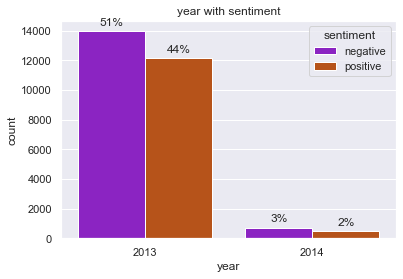

In [46]:
def barplot(column,data):
    bar_plot1=sns.countplot(x=column,data=data,hue='sentiment',palette="gnuplot")
   
    total=len(data[column])
    for p in bar_plot1.patches:
        percentage='{:.0f}%'.format(100*p.get_height()/total)
        height=p.get_height()
        sns.set(style="darkgrid",palette='deep')
        bar_plot1.text(p.get_x()+p.get_width()/2,height+400,percentage,ha='center')
        plt.title('year with sentiment')
barplot('year',df)

In [61]:
ax= px.treemap(df,path=["date"])
ax.show()

In [62]:
ax= px.treemap(df,path=["date",'sentiment'],color='sentiment')
ax.show()

In [59]:
df['name'].iplot(kind='hist', xTitle='name',
                  yTitle='count', title='Claps Distribution')

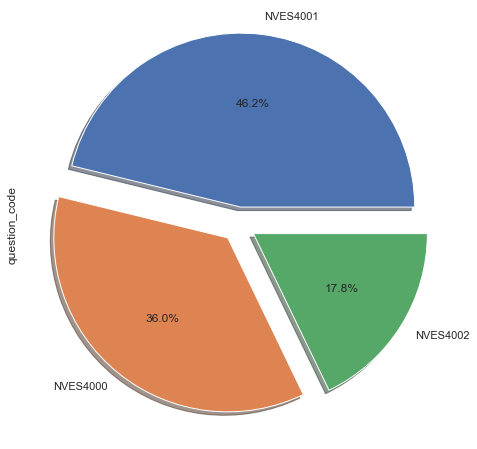

In [65]:
df['question_code'].value_counts().plot.pie(explode=[0.1,0.1,0.1],autopct='%1.1f%%',shadow=True,figsize=(10,8))
plt.show()

In [64]:
ax= px.treemap(df,path=["question_code",'sentiment'],color='sentiment')
ax.show()

## Model Building

In [15]:
Independent_var = df.text
Dependent_var = df.sentiment

IV_train, IV_test, DV_train, DV_test = train_test_split(Independent_var, Dependent_var, test_size = 0.1, random_state = 225)

print('IV_train :', len(IV_train))
print('IV_test  :', len(IV_test))
print('DV_train :', len(DV_train))
print('DV_test  :', len(DV_test))

IV_train : 24534
IV_test  : 2726
DV_train : 24534
DV_test  : 2726


In [16]:
tvec = TfidfVectorizer()
clf1 = LogisticRegression(solver = "lbfgs")

In [17]:
logit = Pipeline([('vectorizer',tvec),('classifier',clf1)])
logit.fit(IV_train, DV_train)
predictions = logit.predict(IV_test)
confusion_matrix(predictions, DV_test)

array([[1393,  176],
       [  92, 1065]], dtype=int64)

In [18]:
print("Accuracy for logistic: ", accuracy_score(predictions, DV_test))
print("Precision for logistic : ", precision_score(predictions, DV_test, average = 'weighted'))
print("Recall for logistic : ", recall_score(predictions, DV_test, average = 'weighted'))

Accuracy for logistic:  0.9016874541452677
Precision for logistic :  0.9041485447558698
Recall for logistic :  0.9016874541452677


In [124]:
clf2=MultinomialNB()
NB = Pipeline([('vectorizer',tvec),('classifier',clf2)])
NB.fit(IV_train, DV_train)
predictions = NB.predict(IV_test)
confusion_matrix(predictions, DV_test)

array([[1298,  314],
       [ 187,  927]], dtype=int64)

In [125]:
print("Accuracy for NB: ", accuracy_score(predictions, DV_test))
print("Precision for NB : ", precision_score(predictions, DV_test, average = 'weighted'))
print("Recall for NB : ", recall_score(predictions, DV_test, average = 'weighted'))

Accuracy for NB:  0.8162142333088774
Precision for NB :  0.8221354257159524
Recall for NB :  0.8162142333088774


In [130]:
SVM = svm.SVC(kernel='linear')
SVM = Pipeline([('vectorizer',tvec),('classifier',clf2)])
SVM.fit(IV_train, DV_train)
predictions = SVM.predict(IV_test)
confusion_matrix(predictions, DV_test)

array([[1298,  314],
       [ 187,  927]], dtype=int64)

In [129]:
print("Accuracy for SVM: ", accuracy_score(predictions, DV_test))
print("Precision for SVM : ", precision_score(predictions, DV_test, average = 'weighted'))
print("Recall for SVM : ", recall_score(predictions, DV_test, average = 'weighted'))

Accuracy for SVM:  0.8162142333088774
Precision for SVM :  0.8221354257159524
Recall for SVM :  0.8162142333088774


In [19]:
example = ["extremely unhappy with the gas mileage that the car gets.  The salesman's selling point of the vehicle was the sticker and the gas mileage it is expected to get.  I have talked to the service department and they have no answers as to why it would be so low.   My main focus on buying a new car was gas mileage and in my opinion this car has failed my expectation and the sticker in the window."]
result = logit.predict(example)

In [20]:
print(result)

['negative']


In [21]:
with open('model.pkl','wb')as f:
    pickle.dump(logit,f)
    

In [148]:
# open a file, where you want to store the data
file = open('logit.pkl', 'wb')
# dump information to that file
pickle.dump(logit, file)
model=pickle.load(open('logit.pkl','rb'))
